In [419]:
import pymc3 as pm
import arviz as az
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The variable of interest in this analysis represents if a rider finished on the podium in a race. It needs to be created from the result of the rider in the race.

In [420]:
df = pd.DataFrame()
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "final_project/data/*.csv"))
for f in csv_files:
    df_races = pd.read_csv(f)
    df_races['top3'] = df_races['result'].isin([1.0, 2.0, 3.0, '1', '2', '3', 1, 2, 3]).astype(int)
    df_races.to_csv(f, index = False, encoding='utf-8')

In [421]:
for f in csv_files:
    df_races = pd.read_csv(f)
    df_races = df_races.dropna()
    df_races['rider'] = f[77:-4]
    df_subset = df_races.loc[:, ['rider', 'name', 'top3']]
    df = df.append(df_subset)

NA row represent results in general and special classifications of stage races, they are dropped since they are not of interest in the project

# Description of the data

The complete dataset is the following:

In [422]:
df

rider                                          name  top3
0      adam-yates                         Il Lombardia (1.UWT)      0
1      adam-yates                   Tre Valli Varesine (1.Pro)      0
3      adam-yates      Grand Prix Cycliste de Montréal (1.UWT)      0
4      adam-yates        Grand Prix Cycliste de Québec (1.UWT)      0
9      adam-yates              Stage 4 - Schiltach › Stuttgart      0
..            ...                                           ...   ...
55  wout-van-aert          Stage 4 (ITT) - Domérat › Montluçon      1
56  wout-van-aert          Stage 3 - Vierzon › Dun-le-Palestel      1
57  wout-van-aert                Stage 2 - Auffargis › Orléans      1
58  wout-van-aert  Stage 1 - Mantes-la-Ville › Mantes-la-Ville      1
59  wout-van-aert             Omloop Het Nieuwsblad ME (1.UWT)      1

[2210 rows x 3 columns]

After cleaning the dataset 2210 results remain.

In [423]:
df

rider                                          name  top3
0      adam-yates                         Il Lombardia (1.UWT)      0
1      adam-yates                   Tre Valli Varesine (1.Pro)      0
3      adam-yates      Grand Prix Cycliste de Montréal (1.UWT)      0
4      adam-yates        Grand Prix Cycliste de Québec (1.UWT)      0
9      adam-yates              Stage 4 - Schiltach › Stuttgart      0
..            ...                                           ...   ...
55  wout-van-aert          Stage 4 (ITT) - Domérat › Montluçon      1
56  wout-van-aert          Stage 3 - Vierzon › Dun-le-Palestel      1
57  wout-van-aert                Stage 2 - Auffargis › Orléans      1
58  wout-van-aert  Stage 1 - Mantes-la-Ville › Mantes-la-Ville      1
59  wout-van-aert             Omloop Het Nieuwsblad ME (1.UWT)      1

[2210 rows x 3 columns]

**top3**: how many races the rider finished in the top 3 positions in 2022
**rider**: how many races the rider participated in and completed in 2022
**frequency**: placements on the podium / races completed in 2022

In [424]:
df_grouped = df.groupby('rider').agg({'top3': 'sum', 'rider': 'size'})
df_grouped['frequency'] = df_grouped['top3']/df_grouped['rider']


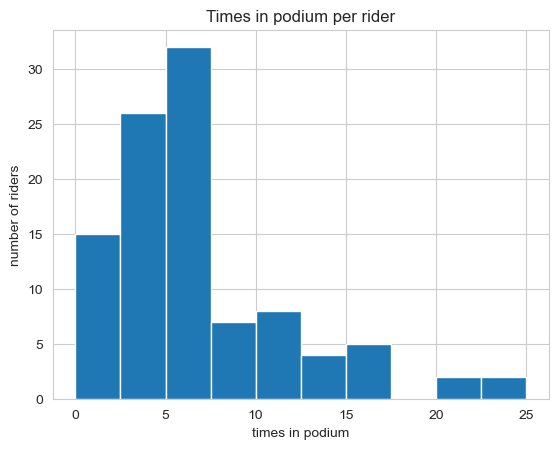

In [425]:
df_grouped['top3'].hist()
plt.xlabel("times in podium")
plt.ylabel("number of riders")
plt.title("Times in podium per rider")
plt.show()

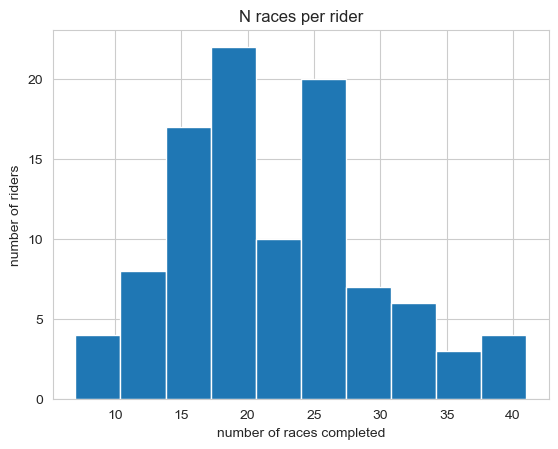

In [426]:
df_grouped['rider'].hist()
plt.xlabel("number of races completed")
plt.ylabel("number of riders")
plt.title("N races per rider")
plt.show()

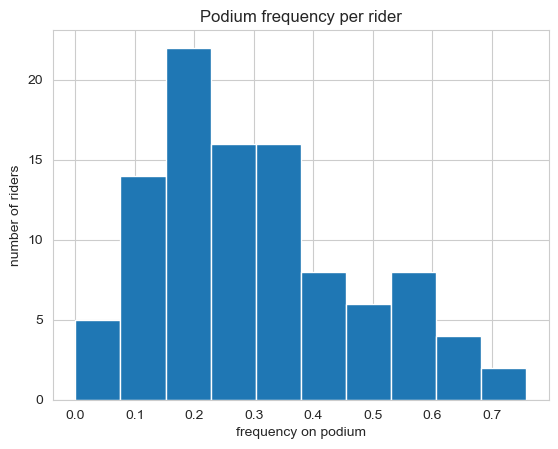

In [427]:
df_grouped['frequency'].hist()
plt.xlabel("frequency on podium")
plt.ylabel("number of riders")
plt.title("Podium frequency per rider")
plt.show()

# Hypotesis testing

## Hypotesis 1: Wout Van Aert finishing on the podium

In [428]:
df_grouped['frequency'].mean()

0.29594150761352267

The mean frequency of finishing on the podium for the first 100 cyclist is 0.30. Wout Van Aert is one of the best riders in the peloton and is able to perform well in different races. The test is to check if $\theta = 0.30$ for him.

$H_0$ = Van Aert finishes in top 3 with $\theta = 0.30$
$H_1$ = Van Aert finishes in top 3 with $\theta \neq 0.30$

### Tuning of the prior
The prior for this task is a Beta distribution. To tune it according to the real distribution of podiums for riders, the website [Interactive Beta distribution](https://homepage.divms.uiowa.edu/~mbognar/applets/beta.html) was used.

In [429]:
df_grouped['frequency'].mean(), df_grouped['frequency'].std(), df_grouped['frequency'].quantile(0.05), df_grouped['frequency'].quantile(0.95)

(0.29594150761352267,
 0.16736744869600892,
 0.07692307692307693,
 0.6097560975609756)

In [430]:
df_grouped['frequency'].mode()

0    0.333333
Name: frequency, dtype: float64

a = 2
b = 4.8
μ=E(X)=0.2985
σ=SD(X)=0.1649

In [431]:
from scipy.stats import beta, binom
prior = beta(a=2, b=4.8)
#q1 = beta.ppf(q=[0.05,0.95],a=2, b=4.8)
q1 = prior.ppf(q=[0.05,0.95])
q1

array([0.06516522, 0.59564004])

### Posterior for Wout Van Aert
The posterior for Wout Van Aert is computed based on his podium results:

#### Analytical approach

In [432]:
df_grouped.loc[ 'wout-van-aert' , : ]

top3         25.000000
rider        33.000000
frequency     0.757576
Name: wout-van-aert, dtype: float64

y = 25
n = 33
$\theta$ = 0.76

In [433]:
beta.ppf(a=2+25, b=4.8+8, q=[0.05,0.25,0.5,0.75,0.95])

array([0.55297311, 0.63003666, 0.68140706, 0.72997936, 0.79349186])

HDI 94%

In [434]:
x = np.linspace(0,1, 100)
y = beta.pdf(x, 27, 12.8)
ci = beta.interval(alpha=0.94, a=27, b=12.8)

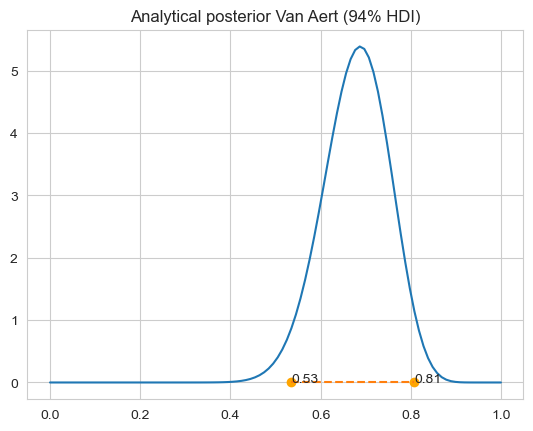

In [435]:
labels = {'a', 'b'}
plt.plot(x,y)
plt.plot(x[int(ci[0]*100)], 0, 'o', color='orange')
plt.text(x[int(ci[0]*100)], 0, round(ci[0], 2))
plt.plot(x[int(ci[1]*100)], 0, 'o', color='orange')
plt.text(x[int(ci[1]*100)], 0, round(ci[1], 2), )
plt.plot([x[int(ci[0]*100)],x[int(ci[1]*100)]] ,[0,0], linestyle="--")
plt.title("Analytical posterior Van Aert (94% HDI)")
plt.show()

$H_0$ is false, since the value 0.3 is not in the 94 % HDI

#### Probabilistic Programming approach
The same posterior is computed with pymc3

In [436]:
data_wva = np.array(df.loc[df['rider'] == 'wout-van-aert']['top3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E10AE6D90>,
      dtype=object)

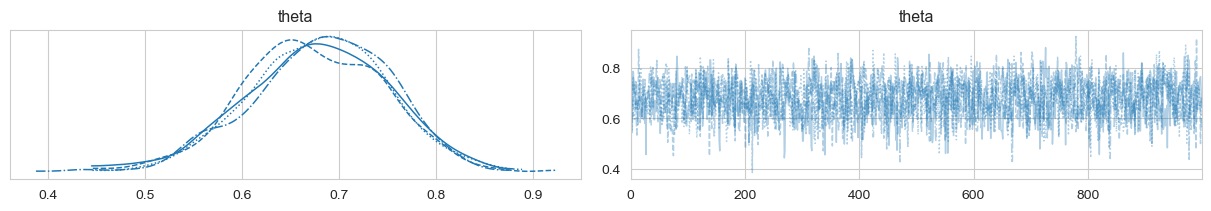

In [437]:
with pm.Model() as wva_model:

    theta = pm.Beta('theta', alpha=2, beta=4.8)


    #Likelihood, characterized by the keyword  `observed`.
    y = pm.Binomial('y',n=len(data_wva), p=theta, observed=sum(data_wva))
    wva_trace = pm.sample(return_inferencedata=True)
az.plot_trace(wva_trace)

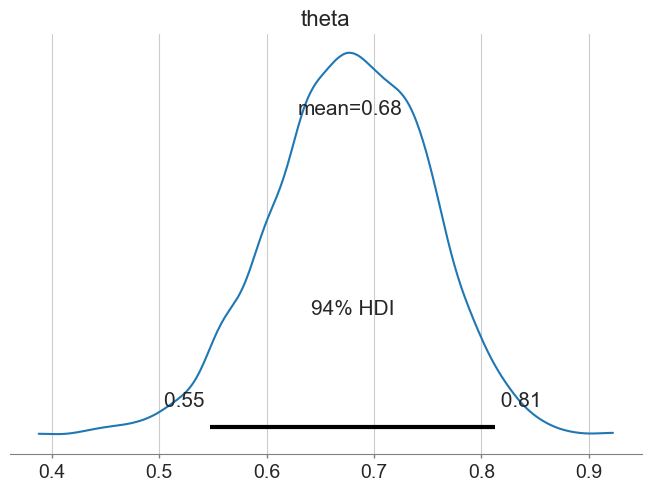

In [438]:
az.plot_posterior(wva_trace)

The result is the same obtained with the analytical approach, the hypotesis $H_0$ is rejected.

### Evaluation of prior sensitivity

In the dataset riders are categorized as one-day races specialists and stage-races general classification specialists. Wout Van Aert is a one-day race specialist. The new prior is the distribution of podiums only for one-day races specialists.

In [439]:
df_specialties = pd.read_csv('final_project/specialties.csv')
df_specialties = df_specialties[["filename", "gc"]]
df_specialties = df_specialties.set_index("filename")
result = df_grouped.join(df_specialties)
result = result.drop_duplicates()
one_day_racers = result[result['gc'] == 0]
one_day_racers['frequency'].mean(),one_day_racers['frequency'].std(),one_day_racers['frequency'].quantile(0.05),one_day_racers['frequency'].quantile(0.95)

(0.33320651218940106,
 0.1891177572945693,
 0.07922077922077922,
 0.6211538461538462)

In [440]:
prior_one_day = beta(a=1.7, b=3.4)
q1 = prior_one_day.ppf(q=[0.05,0.95])
q1

array([0.06292888, 0.68318272])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E156960D0>,
      dtype=object)

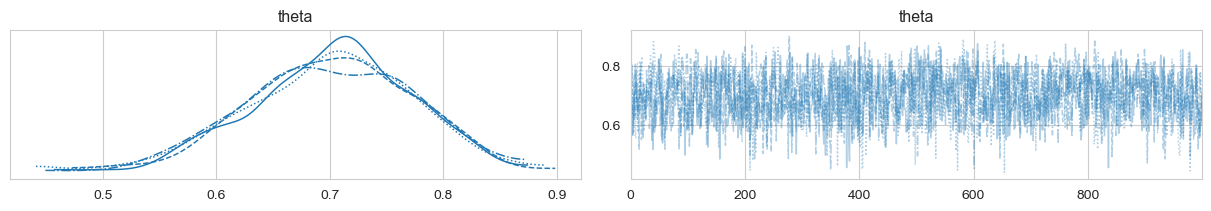

In [441]:
with pm.Model() as wva_model:

    theta = pm.Beta('theta', alpha=1.7, beta=3.4)


    #Likelihood, characterized by the keyword  `observed`.
    y = pm.Binomial('y',n=len(data_wva), p=theta, observed=sum(data_wva))
    wva_trace = pm.sample(return_inferencedata=True)
az.plot_trace(wva_trace)

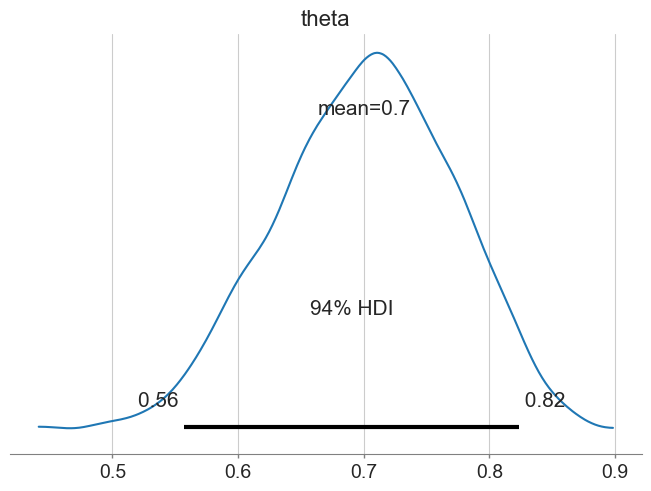

In [442]:
az.plot_posterior(wva_trace)

In [443]:
with pm.Model() as prior_comparison_model:
    theta2 = pm.Beta('theta2', alpha=1.7, beta=3.4)

    y_wva2 = pm.Binomial('y_wva2',n=len(data_wva), p=theta2, observed=sum(data_wva))
    prior_comparison_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8811875428330971, but should be close to 0.8. Try to increase the number of tuning steps.


In [444]:
a = az.summary(wva_trace)
b = az.summary(prior_comparison_trace)
pd.concat([a,b])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.700  0.073   0.557    0.824      0.002    0.001    1444.0    2329.0   
theta2  0.703  0.074   0.564    0.844      0.002    0.001    1541.0    2325.0   

        r_hat  
theta     1.0  
theta2    1.0

The 2 posteriors are practically the same, the results are thus robust to the specification of the prior.

## Hypotesis 2: Wout Van Aert vs Mathieu Van Der Poel comparison
Wout Van Aert (WVA) and Mathieu Van Der Poel (VDP) are riders with similar characteristics. Their rivalry comes from their times in cyclocross, and now they are both racing in road cycling.

$H_0$ = Van Aert and Van Der Poel have the same proportion of podiums
$H_1$ = Van Aert and Van Der Poel have a different proportion of podiums

In [445]:
data_vdp = np.array(df.loc[df['rider'] == 'mathieu-van-der-poel']['top3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E18964910>,
      dtype=object)

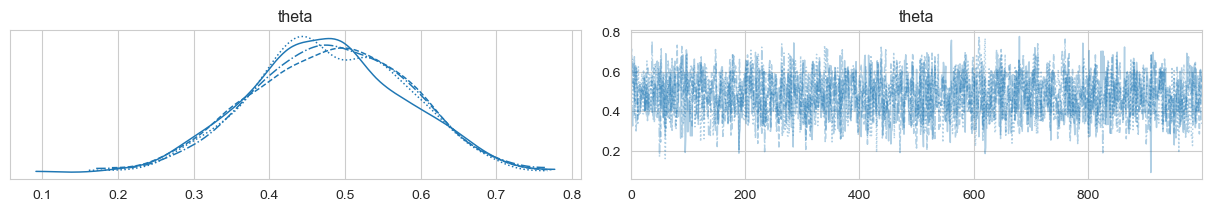

In [446]:
with pm.Model() as vdp_model:

    theta = pm.Beta('theta', alpha=2, beta=4.8)


    #Likelihood, characterized by the keyword  `observed`.
    y_vdp = pm.Binomial('y',n=len(data_vdp), p=theta, observed=sum(data_vdp))
    vdp_trace = pm.sample(return_inferencedata=True)
az.plot_trace(vdp_trace)

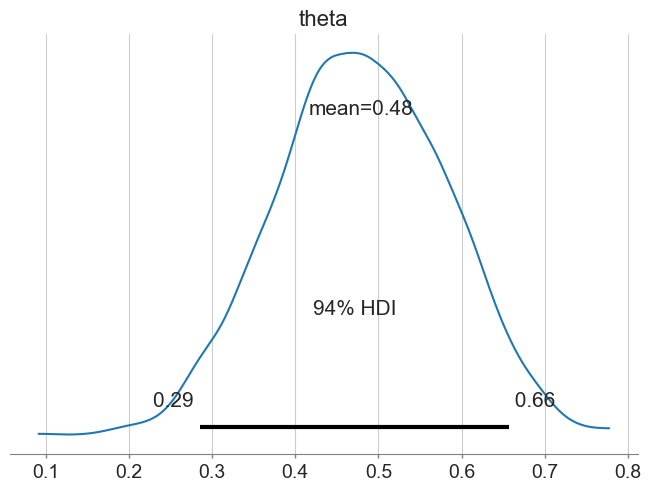

In [447]:
az.plot_posterior(vdp_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8876539215230135, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027DFFD656D0>,
      dtype=object)

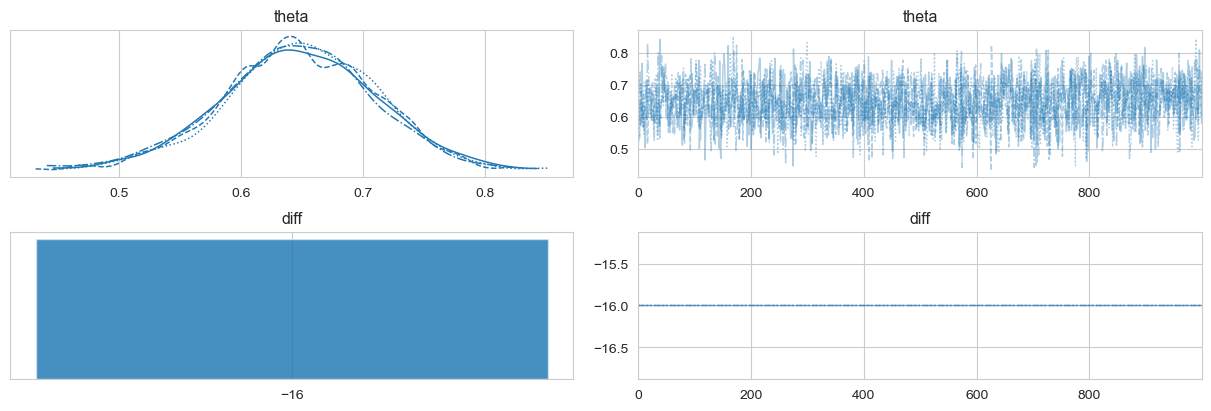

In [448]:
with pm.Model() as diff_model:
    theta = pm.Beta('theta', alpha=2, beta=4.8)

    y_wva = pm.Binomial('y_wva',n=len(data_wva), p=theta, observed=sum(data_wva))
    y_vdp = pm.Binomial('y_vdp',n=len(data_vdp), p=theta, observed=sum(data_vdp))
    diff = pm.Deterministic('diff', y_vdp - y_wva)
    diff_trace = pm.sample(return_inferencedata=True)
az.plot_trace(diff_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027D806BAA60>,
      dtype=object)

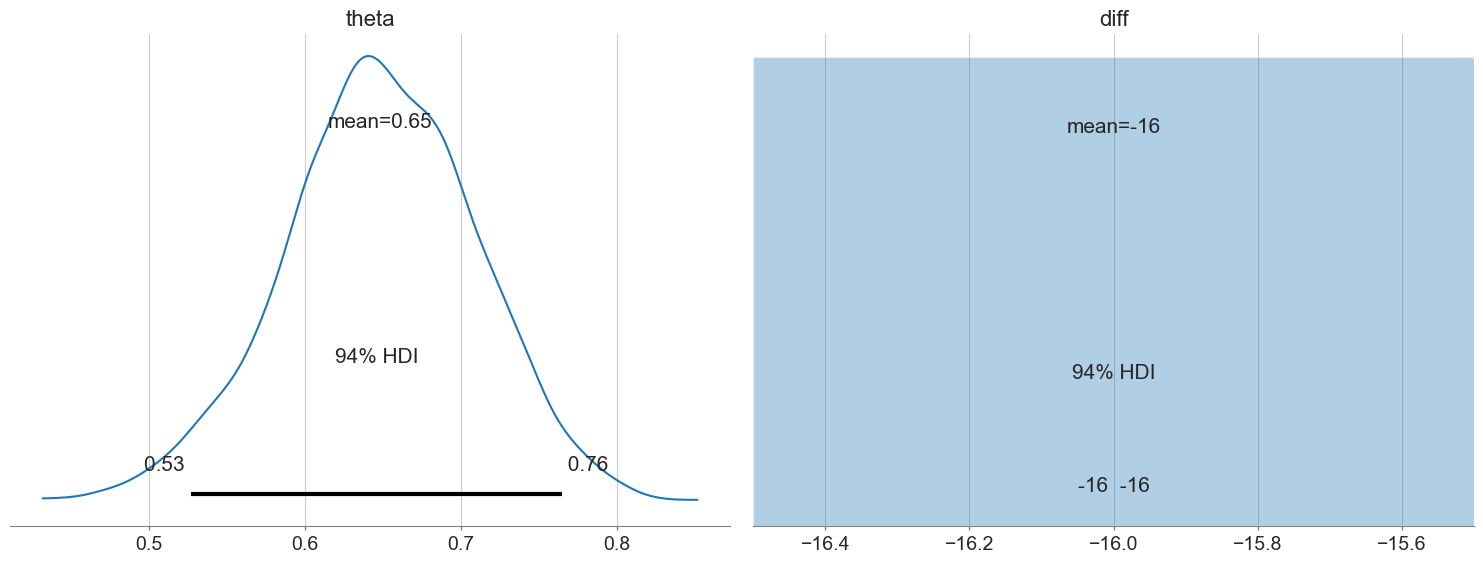

In [449]:
az.plot_posterior(diff_trace)

0 is not included in the 94% HDI. It is possible to affirm the proportion of podiums is different between the two riders.

### Evaluation of prior sensitivity

In [450]:
with pm.Model() as diff_model:
    theta = pm.Beta('theta', alpha=1.7, beta=3.4)

    y_wva_new_prior = pm.Binomial('y_wva_new_prior',n=len(data_wva), p=theta, observed=sum(data_wva))
    y_vdp_new_prior = pm.Binomial('y_vdp_new_prior',n=len(data_vdp), p=theta, observed=sum(data_vdp))
    diff_new_prior = pm.Deterministic('diff', y_vdp_new_prior - y_wva_new_prior)
    diff_trace_new_prior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [451]:
a = az.summary(diff_trace)
b = az.summary(diff_trace_new_prior)
pd.concat([a,b])

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.648  0.063   0.527    0.765      0.001    0.001    1876.0    2375.0   
diff  -16.000  0.000 -16.000  -16.000      0.000    0.000    4000.0    4000.0   
theta   0.662  0.064   0.533    0.774      0.002    0.001    1782.0    2456.0   
diff  -16.000  0.000 -16.000  -16.000      0.000    0.000    4000.0    4000.0   

       r_hat  
theta    1.0  
diff     NaN  
theta    1.0  
diff     NaN

The 2 differences are the same, the results are thus robust to the specification of the prior.

## Hypotesis 3: Tadej Pogacar obtains a larger proportion of podiums with respect to Jonas Vingegaard
Tadej Pogacar and Jonas Vingegaard are two young riders who dominated the last editions of Le Tour De France. They changed the way Le Tour de France is raced, riding in an aggressive and spectacular manner. By the way they are riders with different characteristics: Vingegaard obtains most of his results in stage races, while Pogacar is competitive both in one-day and stage races.

$H_0$ = Pogacar has a better proportion of podiums than Vingegaard
$H_1$ = Pogacar and Vingegaar have the same proportion of podiums, or Vingegaard has a better one

In [452]:
data_pog = np.array(df.loc[df['rider'] == 'tadej-pogacar']['top3'])
data_vin = np.array(df.loc[df['rider'] == 'jonas-vingegaard-rasmussen']['top3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gc_theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E0F8CAEB0>,
      dtype=object)

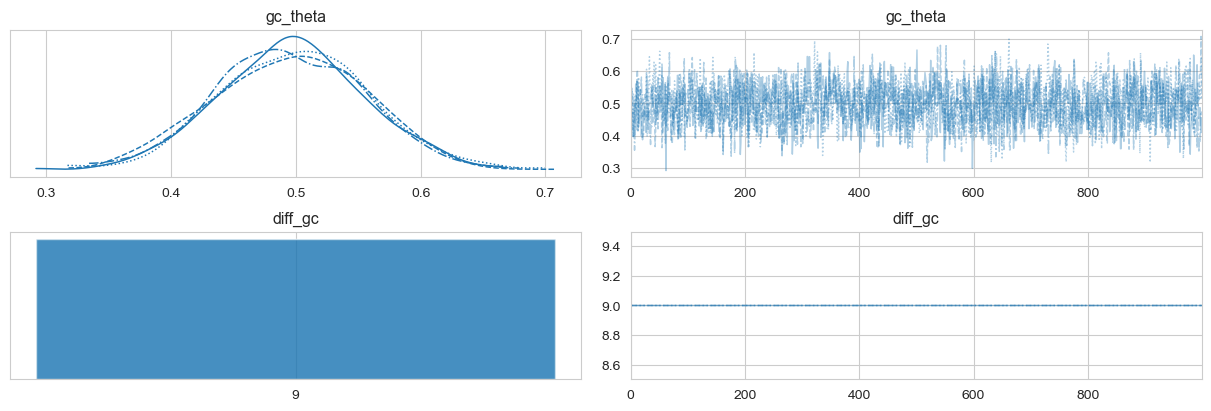

In [453]:
with pm.Model() as gc_diff_model:
    gc_theta = pm.Beta('gc_theta', alpha=2, beta=4.8)

    y_pog = pm.Binomial('y_pog',n=len(data_pog), p=gc_theta, observed=sum(data_pog))
    y_vin = pm.Binomial('y_vin',n=len(data_vin), p=gc_theta, observed=sum(data_vin))
    diff_gc = pm.Deterministic('diff_gc', y_pog - y_vin)
    diff_trace_gc = pm.sample(return_inferencedata=True)
az.plot_trace(diff_trace_gc)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027D8039D520>,
      dtype=object)

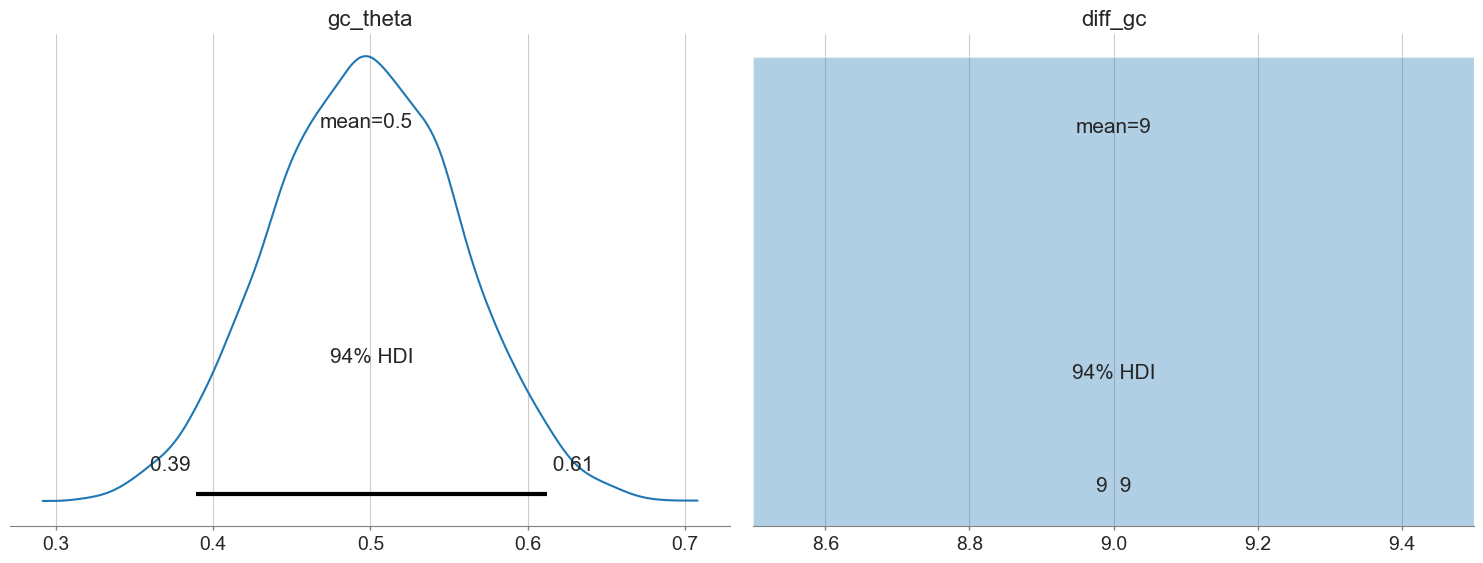

In [454]:
az.plot_posterior(diff_trace_gc)

From the difference distribution $H_0$ cannot be rejected. Pogacar looks to have better results than Vingegaard.

### Evaluation of prior sensitivity

In [455]:
gc_racers = result[result['gc'] == 1]
gc_racers['frequency'].mean(),gc_racers['frequency'].std(),gc_racers['frequency'].quantile(0.05),gc_racers['frequency'].quantile(0.95)

(0.274658931129299,
 0.14475186055200054,
 0.07692307692307693,
 0.4989999999999999)

In [456]:
prior_gc = beta(a=2, b=5.3)
q1 = prior_gc.ppf(q=[0.05,0.95])
q1

array([0.05967094, 0.56212252])

In [457]:
with pm.Model() as gc_diff_model_new_prior:
    gc_theta_new_prior = pm.Beta('gc_theta_new_prior', alpha=2, beta=5.3)

    y_pog_new_prior = pm.Binomial('y_pog_new_prior',n=len(data_pog), p=gc_theta_new_prior, observed=sum(data_pog))
    y_vin_new_prior = pm.Binomial('y_vin_new_prior',n=len(data_vin), p=gc_theta_new_prior, observed=sum(data_vin))
    diff_gc_new_prior = pm.Deterministic('diff_gc_new_prior', y_pog_new_prior - y_vin_new_prior)
    diff_trace_gc_new_prior = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gc_theta_new_prior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [458]:
a = az.summary(diff_trace_gc)
b = az.summary(diff_trace_gc_new_prior)
pd.concat([a,b])

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
gc_theta            0.497  0.06   0.389    0.612      0.001    0.001   
diff_gc             9.000  0.00   9.000    9.000      0.000    0.000   
gc_theta_new_prior  0.495  0.06   0.383    0.606      0.001    0.001   
diff_gc_new_prior   9.000  0.00   9.000    9.000      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
gc_theta              1654.0    2784.0    1.0  
diff_gc               4000.0    4000.0    NaN  
gc_theta_new_prior    1776.0    2891.0    1.0  
diff_gc_new_prior     4000.0    4000.0    NaN

The distribution is similar. The results are thus robust to the specification of the prior.

# Vingegaard

In [459]:
data_vin

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1], dtype=int64)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_vin]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027DFA267460>,
      dtype=object)

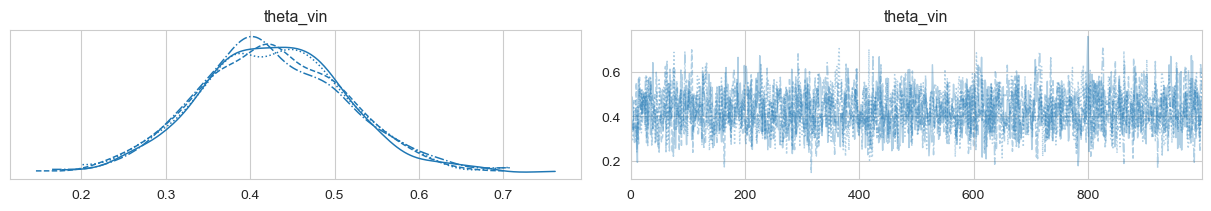

In [460]:
with pm.Model() as vin_model:

    theta_vin = pm.Beta('theta_vin', alpha=2, beta=4.8)


    #Likelihood, characterized by the keyword  `observed`.
    y_vin = pm.Binomial('y_vin',n=len(data_vin), p=theta_vin, observed=sum(data_vin))
    vin_trace = pm.sample(return_inferencedata=True)
az.plot_trace(vin_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_vin_gc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E13ADB520>,
      dtype=object)

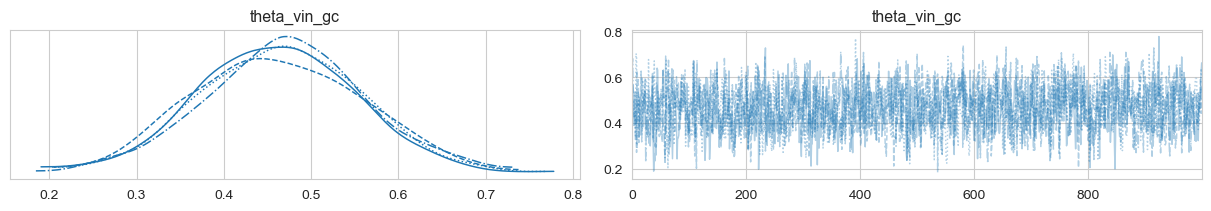

In [461]:
with pm.Model() as vin_model_gc:

    theta_vin_gc = pm.Beta('theta_vin_gc', alpha=1, beta=1)


    #Likelihood, characterized by the keyword  `observed`.
    y_vin_gc = pm.Binomial('y_vin_gc',n=len(data_vin), p=theta_vin_gc, observed=sum(data_vin))
    vin_trace_gc = pm.sample(return_inferencedata=True)
az.plot_trace(vin_trace_gc)

In [462]:
a = az.summary(vin_trace)
b = az.summary(vin_trace_gc)
pd.concat([a,b])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_vin     0.426  0.086   0.261    0.586      0.002    0.001    1784.0   
theta_vin_gc  0.464  0.092   0.291    0.635      0.002    0.002    1668.0   

              ess_tail  r_hat  
theta_vin       2345.0    1.0  
theta_vin_gc    2677.0    1.0

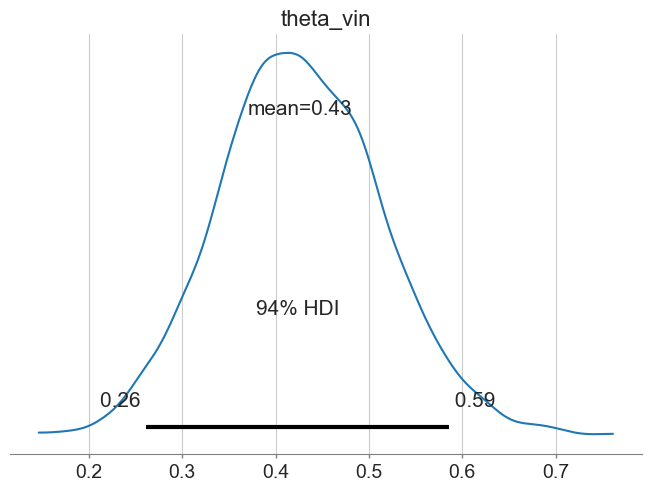

In [463]:
az.plot_posterior(vin_trace)

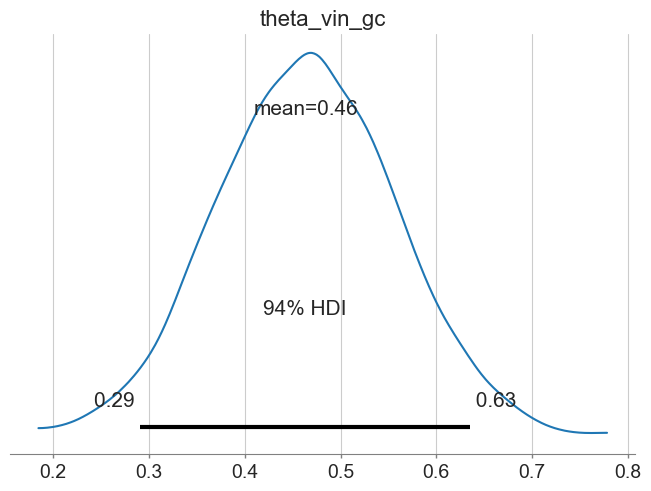

In [464]:
az.plot_posterior(vin_trace_gc)

# Hierarchiacal Model
$\mu \sim Beta(a_\mu, b_\mu)$\
$\kappa \sim |Normal(0, \sigma_\kappa)|$\
$a = \mu * \kappa$\
$b = (1-\mu)*\kappa$\
$\theta \sim Beta(a_i, b_i)$\
$y_i \sim Bern(\theta_i)$

In [465]:
df["rider"] = df["rider"].astype('category')
df["rider_code"] = df["rider"].cat.codes
group_idx =df['rider_code'].values

In [466]:
data=df['top3'].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E36469FA0>,
      dtype=object)

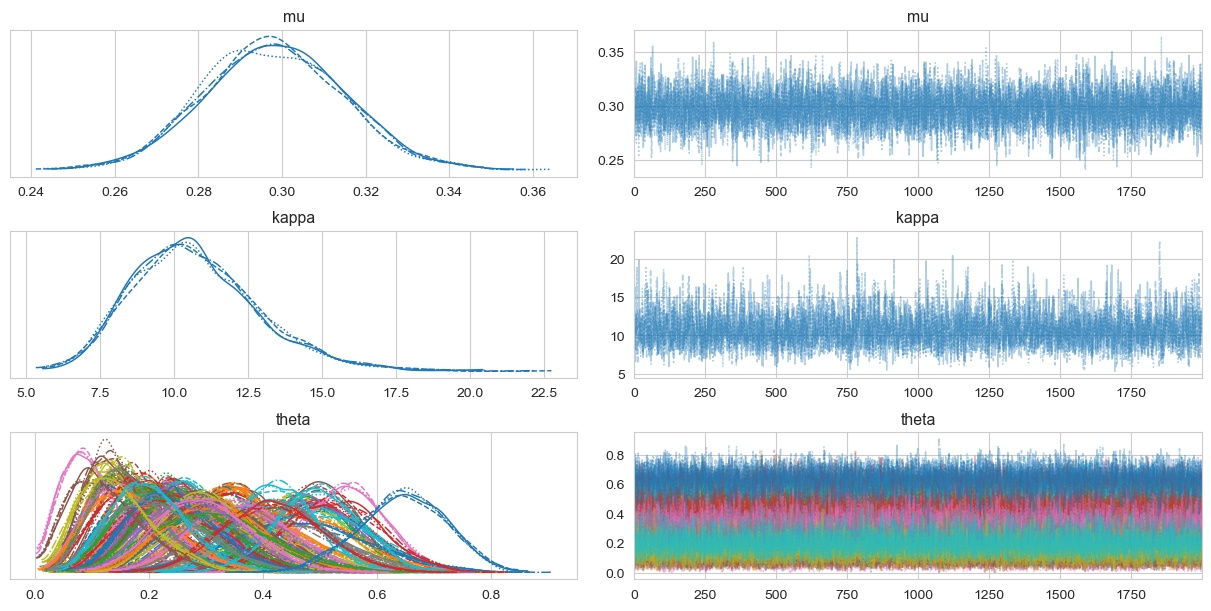

In [467]:
with pm.Model() as model_h:
    mu = pm.Beta('mu', 1., 1.)
    kappa = pm.HalfNormal('kappa', 10)
    theta = pm.Beta('theta', alpha=mu*kappa, beta=(1.0-mu)*kappa, shape=len(np.unique(group_idx)))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    trace_h = pm.sample(2000)
az.plot_trace(trace_h)

In [468]:
az.summary(trace_h)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu           0.298  0.017   0.267    0.328      0.000    0.000    6998.0   
kappa       10.745  2.168   7.012   14.835      0.036    0.025    3840.0   
theta[0]     0.201  0.071   0.075    0.332      0.001    0.001   10060.0   
theta[1]     0.201  0.066   0.084    0.329      0.001    0.000   12746.0   
theta[2]     0.357  0.076   0.221    0.505      0.001    0.001   11862.0   
...            ...    ...     ...      ...        ...      ...       ...   
theta[96]    0.299  0.083   0.143    0.450      0.001    0.001   11918.0   
theta[97]    0.217  0.084   0.071    0.375      0.001    0.001   12980.0   
theta[98]    0.145  0.067   0.028    0.266      0.001    0.000   10210.0   
theta[99]    0.201  0.067   0.078    0.325      0.001    0.000   13517.0   
theta[100]   0.645  0.076   0.501    0.783      0.001    0.001   10711.0   

            ess_tail  r_hat  
mu            6329.0    1.0  
kappa         4750.0    1.0  
theta[0]      4935.0    1.0  
theta[1]      5228.0    1.0  
theta[2]      5802.0    1.0  
...              ...    ...  
theta[96]     4748.0    1.0  
theta[97]     5471.0    1.0  
theta[98]     4652.0    1.0  
theta[99]     5555.0    1.0  
theta[100]    5244.0    1.0  

[103 rows x 9 columns]

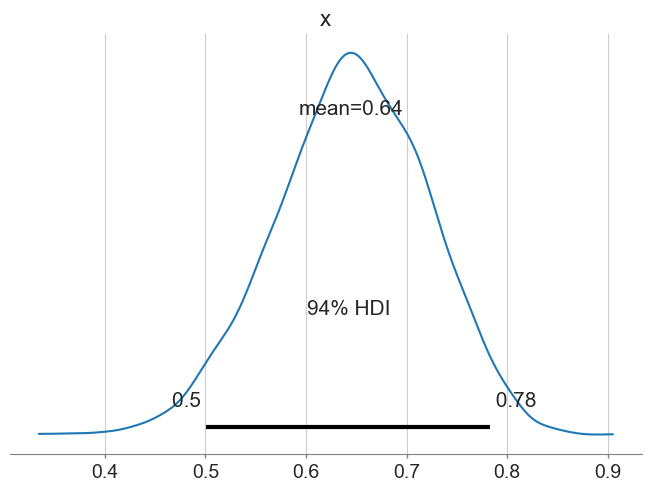

In [469]:
theta_wva = trace_h['theta'][:, 100]
az.plot_posterior(theta_wva)

The posterior of the hierarchical model for Wout Van Aert is slightly lower than the one obtained with a non-hierarchical approach

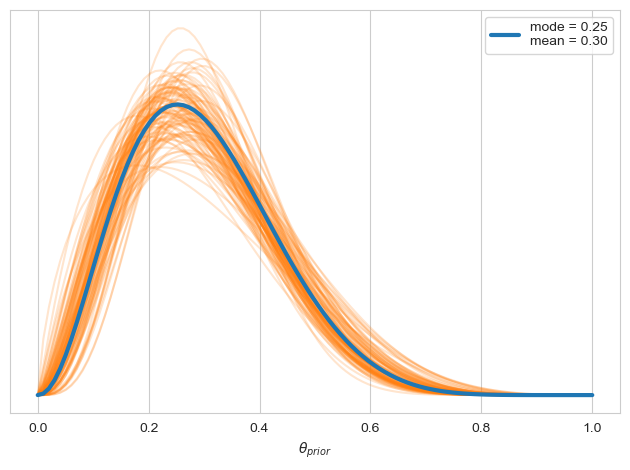

In [470]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['mu'][i]
    k = trace_h['kappa'][i]
    pdf = beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)
u_mean = trace_h['mu'].mean()
k_mean = trace_h['kappa'].mean()
dist = beta(u_mean*k_mean, (1.0-u_mean)*k_mean)

pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

Representation of the prior distribution

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_np, kappa_np, mu_np]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027DB2120520>,
      dtype=object)

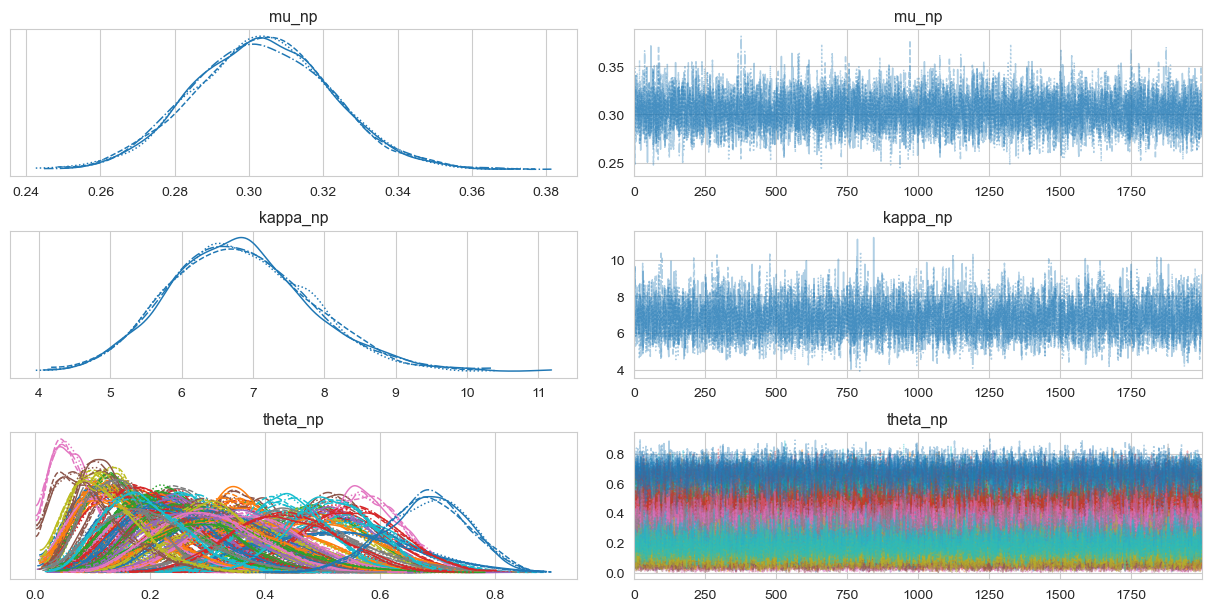

In [471]:
with pm.Model() as model_h_np:
    mu_np = pm.Beta('mu_np', 0.5, 2.)
    kappa_np = pm.HalfNormal('kappa_np', 2)
    theta_np = pm.Beta('theta_np', alpha=mu_np*kappa_np, beta=(1.0-mu_np)*kappa_np, shape=len(np.unique(group_idx)))
    y_np = pm.Bernoulli('y', p=theta_np[group_idx], observed=data)
    trace_h_np = pm.sample(2000)
az.plot_trace(trace_h_np)

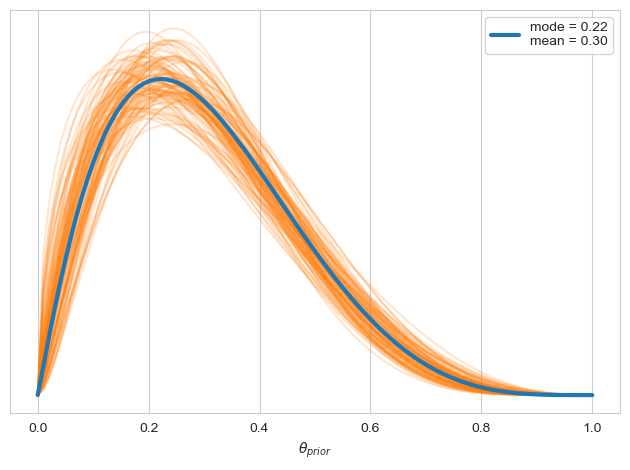

In [472]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h_np), size=100):
    u = trace_h_np['mu_np'][i]
    k = trace_h_np['kappa_np'][i]
    pdf = beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)
u_mean = trace_h_np['mu_np'].mean()
k_mean = trace_h_np['kappa_np'].mean()
dist = beta(u_mean*k_mean, (1.0-u_mean)*k_mean)

pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

In [473]:
a = az.summary(trace_h)
b = az.summary(trace_h_np)
a

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu           0.298  0.017   0.267    0.328      0.000    0.000    6998.0   
kappa       10.745  2.168   7.012   14.835      0.036    0.025    3840.0   
theta[0]     0.201  0.071   0.075    0.332      0.001    0.001   10060.0   
theta[1]     0.201  0.066   0.084    0.329      0.001    0.000   12746.0   
theta[2]     0.357  0.076   0.221    0.505      0.001    0.001   11862.0   
...            ...    ...     ...      ...        ...      ...       ...   
theta[96]    0.299  0.083   0.143    0.450      0.001    0.001   11918.0   
theta[97]    0.217  0.084   0.071    0.375      0.001    0.001   12980.0   
theta[98]    0.145  0.067   0.028    0.266      0.001    0.000   10210.0   
theta[99]    0.201  0.067   0.078    0.325      0.001    0.000   13517.0   
theta[100]   0.645  0.076   0.501    0.783      0.001    0.001   10711.0   

            ess_tail  r_hat  
mu            6329.0    1.0  
kappa         4750.0    1.0  
theta[0]      4935.0    1.0  
theta[1]      5228.0    1.0  
theta[2]      5802.0    1.0  
...              ...    ...  
theta[96]     4748.0    1.0  
theta[97]     5471.0    1.0  
theta[98]     4652.0    1.0  
theta[99]     5555.0    1.0  
theta[100]    5244.0    1.0  

[103 rows x 9 columns]

In [474]:
b

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_np          0.304  0.019   0.269    0.338      0.000    0.000    9981.0   
kappa_np       6.807  0.972   5.083    8.694      0.011    0.008    8035.0   
theta_np[0]    0.189  0.073   0.060    0.326      0.001    0.000   14616.0   
theta_np[1]    0.190  0.068   0.071    0.318      0.001    0.000   14562.0   
theta_np[2]    0.365  0.081   0.211    0.512      0.001    0.001   12300.0   
...              ...    ...     ...      ...        ...      ...       ...   
theta_np[96]   0.301  0.088   0.142    0.466      0.001    0.001   12402.0   
theta_np[97]   0.205  0.090   0.051    0.370      0.001    0.001   13583.0   
theta_np[98]   0.124  0.064   0.018    0.241      0.001    0.000   11562.0   
theta_np[99]   0.192  0.072   0.070    0.329      0.001    0.001   14627.0   
theta_np[100]  0.681  0.073   0.543    0.815      0.001    0.000   13680.0   

               ess_tail  r_hat  
mu_np            6756.0    1.0  
kappa_np         6506.0    1.0  
theta_np[0]      5033.0    1.0  
theta_np[1]      4466.0    1.0  
theta_np[2]      5285.0    1.0  
...                 ...    ...  
theta_np[96]     5455.0    1.0  
theta_np[97]     5620.0    1.0  
theta_np[98]     4641.0    1.0  
theta_np[99]     5013.0    1.0  
theta_np[100]    5886.0    1.0  

[103 rows x 9 columns]

## Pooled model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, kappa, mu]
>BinaryGibbsMetropolis: [predictive]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E133E2E50>,
      dtype=object)

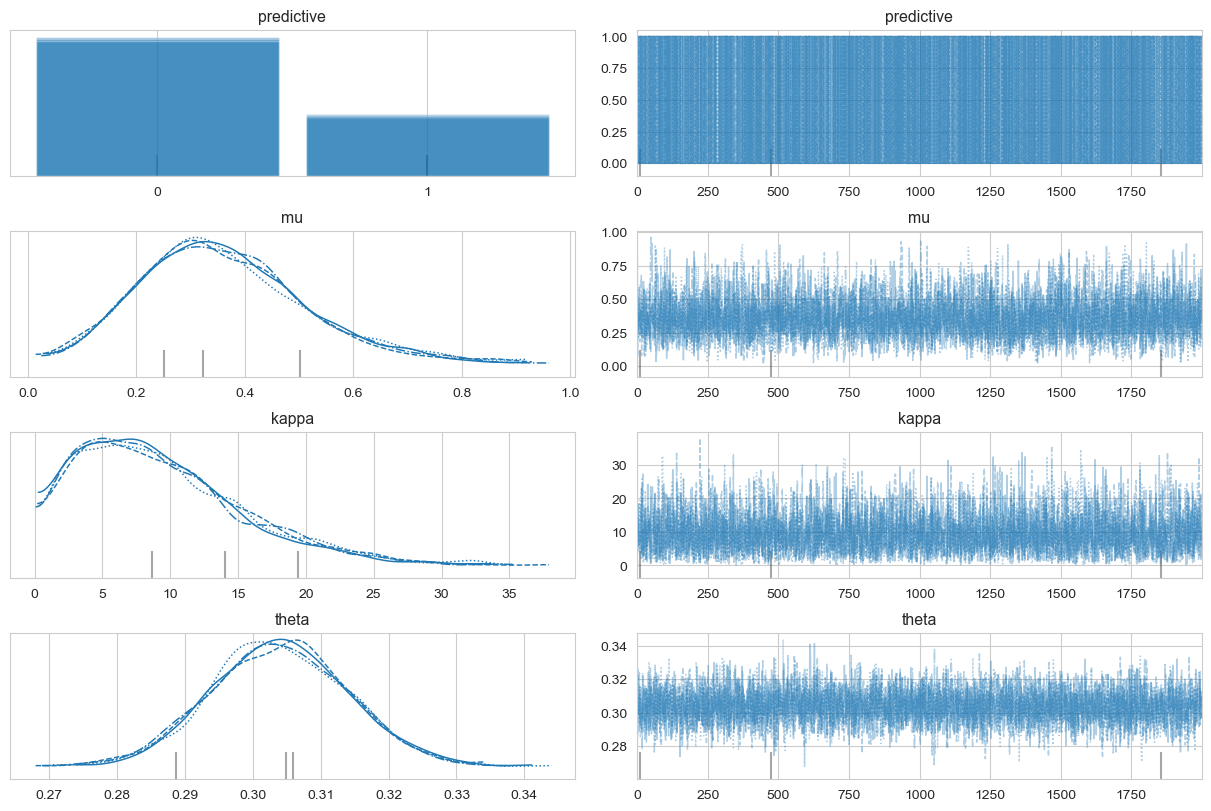

In [475]:
with pm.Model() as model_h_pooled:
    global_mu = pm.Beta('mu', 1., 1.)
    global_kappa = pm.HalfNormal('kappa', 10)
    theta = pm.Beta('theta', alpha=global_mu*global_kappa, beta=(1.0-global_mu)*global_kappa)
    likelihood = pm.Bernoulli('likelihood', p=theta, observed = data)
    predictive =  pm.Bernoulli('predictive', p=theta)
    trace_h_pooled = pm.sample(2000)
az.plot_trace(trace_h_pooled)

In [476]:
az.summary(trace_h_pooled, var_names='predictive')

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
predictive  0.304  0.46     0.0      1.0      0.004    0.003   10976.0   

            ess_tail  r_hat  
predictive    8000.0    1.0

## Model Comparison

In [477]:
hier_waic = az.waic(trace_h, model_h)
hier_waic.waic

-1286.418633470042

In [478]:
pooled_waic = az.waic(trace_h_pooled, model_h_pooled)
pooled_waic.waic

-1357.759815886236

In [539]:
comp_df = az.compare({"model_pooled": trace_h_pooled,
                      "model_hierarchical": trace_h},
                      ic="waic") # ic stands for "information criterion"
comp_df

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         waic     p_waic     d_waic    weight  \
model_hierarchical     0 -1286.418633  65.290706   0.000000  0.980219   
model_pooled           1 -1357.759816   1.039594  71.341182  0.019781   

                           se        dse  warning waic_scale  
model_hierarchical  20.522816   0.000000    False        log  
model_pooled        17.930685  11.950747    False        log

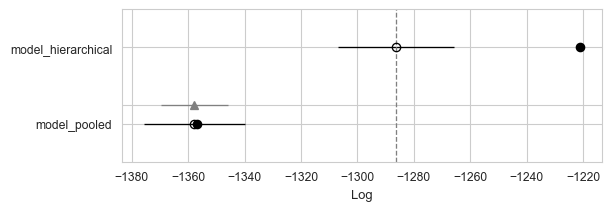

In [540]:
az.plot_compare(comp_df);

## Predictive manually computed

In [541]:
df_group_idx= pd.DataFrame(columns=['groupidx'], data={'groupidx': group_idx})

In [542]:
df_group_idx.drop_duplicates().index

Int64Index([   0,   20,   45,   74,  104,  128,  168,  186,  219,  232,
            ...
            2024, 2039, 2048, 2069, 2087, 2101, 2121, 2134, 2152, 2177],
           dtype='int64', length=101)

In [543]:
pred_distrs = []
group_indices = df_group_idx.drop_duplicates().index
for i in group_indices:
    theta_samples = trace_h['theta']
    theta_group = theta_samples[:, np.where(np.unique(group_idx) == group_idx[i])[0]]
    predictive_distribution = theta_group
    pred_distrs.append(predictive_distribution)

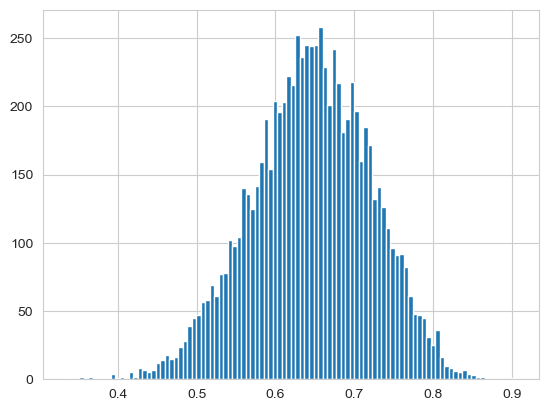

In [544]:
plt.hist(pred_distrs[100], bins=100)
plt.show()

## Distribution for a novel rider

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (8000) than draws (101). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


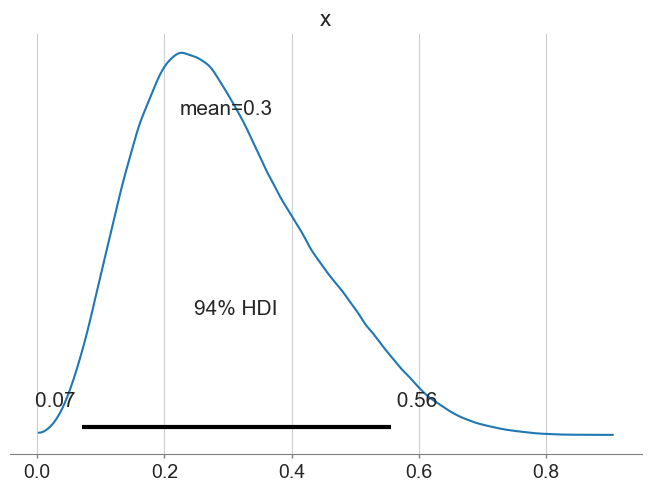

In [545]:
az.plot_posterior(trace_h['theta'])

# UCI points

In [550]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "final_project/data/*.csv"))
df = pd.DataFrame()
for f in csv_files:
    df_races = pd.read_csv(f)
    df_races = df_races.dropna()
    df_races['rider'] = f[77:-4]
    df_subset = df_races.loc[:, ['rider', 'name', 'points']]
    df = df.append(df_subset)

Mean points per rider

In [551]:
rider_points=df.groupby(['rider']).mean().sort_values('points')
rider_points

points
rider                              
damiano-caruso             8.800000
vincenzo-nibali            9.500000
ion-izagirre              10.466667
joao-almeida              10.538462
mattias-skjelmose-jensen  12.076923
...                             ...
christophe-laporte        59.000000
tadej-pogacar             62.447368
annemiek-van-vleuten      65.288462
mathieu-van-der-poel      75.843750
wout-van-aert             80.515152

[101 rows x 1 columns]

In [566]:
riders_mean=df.groupby(['rider']).mean().mean()
riders_mean

points        28.006937
rider_code    50.000000
dtype: float64

In [567]:
riders_std=df.groupby(['rider']).mean().std()
riders_std

points        13.378436
rider_code    29.300171
dtype: float64

Races completed by each rider

In [552]:
rider_count=df.groupby(['rider']).count()
rider_count

name  points
rider                           
adam-yates            20      20
alberto-bettiol       25      25
alejandro-valverde    29      29
aleksandr-vlasov      30      30
alex-aranburu         24      24
...                  ...     ...
valentin-madouas      20      20
victor-campenaerts    13      13
vincenzo-nibali       18      18
warren-barguil        25      25
wout-van-aert         33      33

[101 rows x 2 columns]

In [569]:
with pm.Model() as pooled_model:
    # prior
    global_mean = pm.Normal ('global_mean', 28,  13)
    global_sigma = pm.HalfNormal ('global_sigma', sd = 13)

    #likelihood
    likelihood = pm.Normal ('points', mu = global_mean,  sigma = global_sigma, observed = df["points"])
    trace_pooled = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [554]:
az.summary(trace_pooled)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
global_mean   28.430  0.820  26.804   29.862      0.014    0.010    3231.0   
global_sigma  37.603  0.565  36.588   38.669      0.010    0.007    3322.0   

              ess_tail  r_hat  
global_mean     2659.0    1.0  
global_sigma    2750.0    1.0

In [570]:
with pm.Model() as pooled_model:
    global_mean = pm.Normal ('global_mean', 28,  13)
    global_sigma = pm.HalfNormal ('global_sigma', sd = 13)

    points_likelihood =  pm.Normal ('points', mu = global_mean,  sigma = global_sigma, observed = df["points"])

    predictive = pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [predictive, global_sigma, global_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


In [571]:
az.summary(trace_pooled, var_names='predictive')

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
predictive  27.162  37.673 -45.396   96.395      0.489     0.49    5903.0   

            ess_tail  r_hat  
predictive    3013.0    1.0

In [557]:
n_riders = len(rider_count)

rider = df['rider'].values

df['rider_code']  = df['rider'].astype('category').cat.codes

In [572]:
with pm.Model() as unpooled_model:
    mu_rider =  pm.Normal ('mu_rider', 28,  13, shape = n_riders)

    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 13)

    points_unpooled =  pm.Normal ('points', mu = mu_rider[df['rider_code']],  sigma = global_sigma, observed = df["points"])

    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_rider]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [573]:
df["rider"] = df["rider"].astype("category")
riders = list(df["rider"].cat.categories)

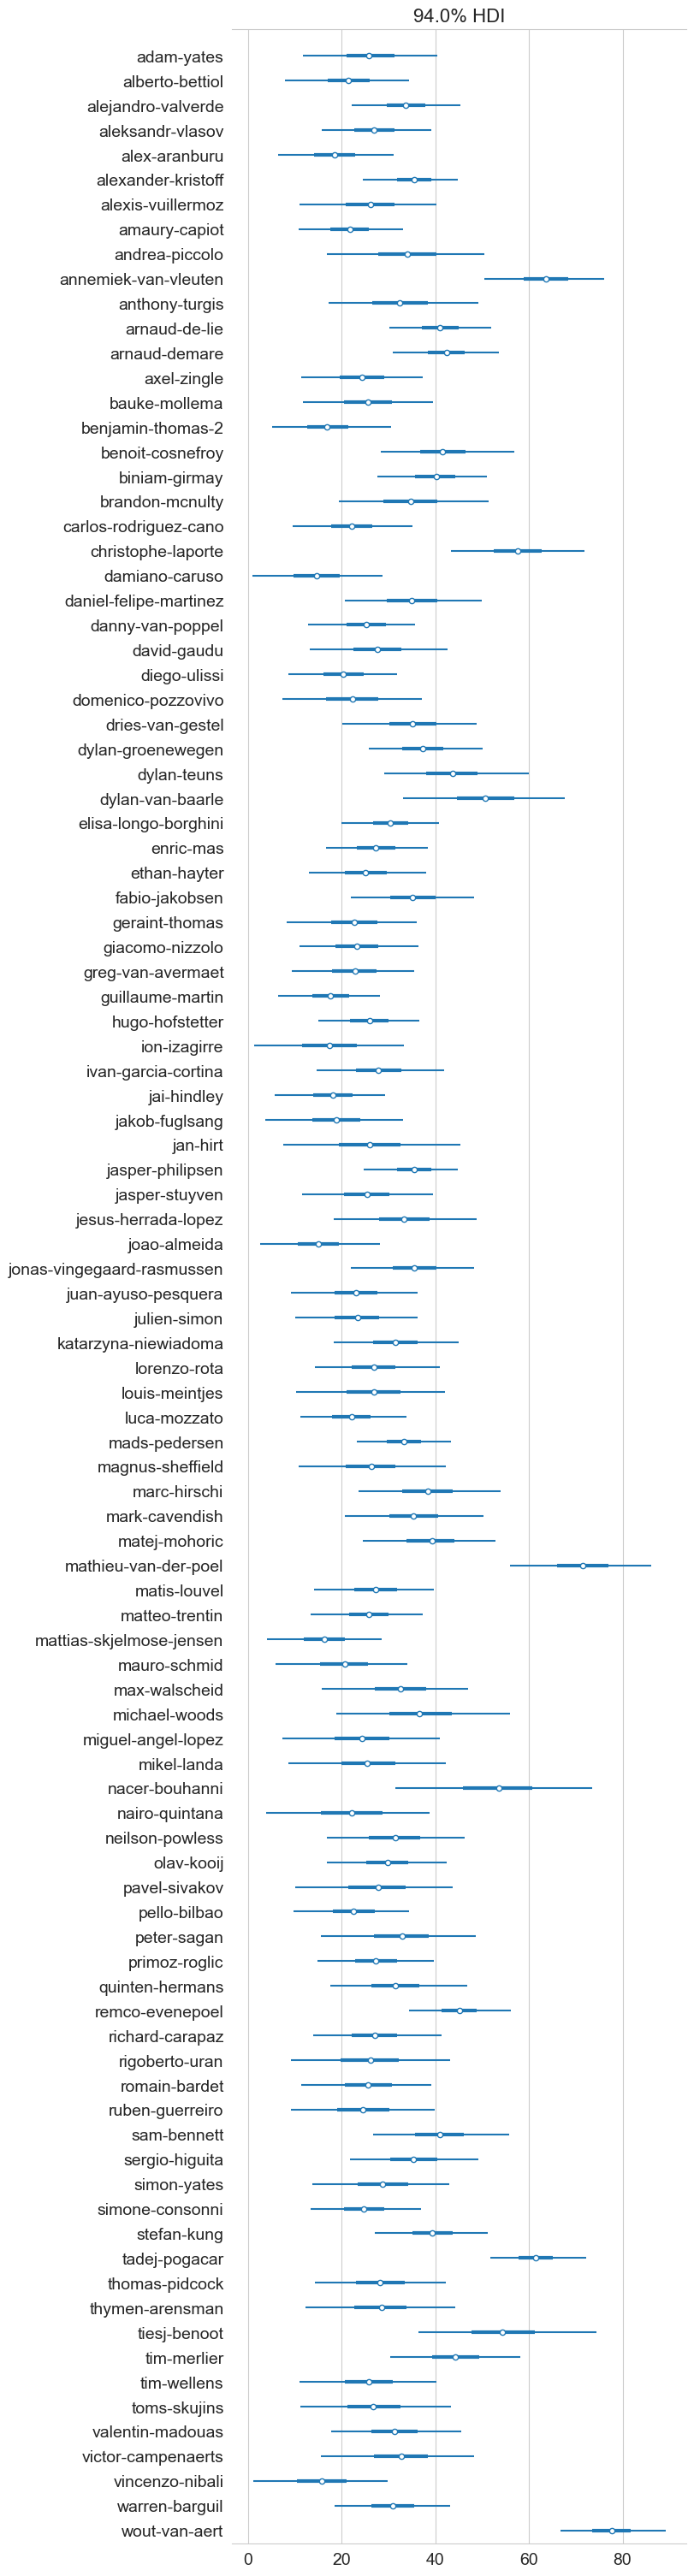

In [560]:
axes = az.plot_forest (trace_unpooled, var_names="mu_rider",
                       combined=True,
                       coords={"mu_rider_dim_0": range(len(riders))}, figsize=(8, 30))
axes[0].set_yticklabels(riders[::-1]);

In [574]:
n_rider = len(rider_count)
with pm.Model() as hier_model:
    mu_pop = pm.Normal ('mu_pop', 28,  13)
    sigma_mu = pm.HalfNormal ('sigma_mu', 13)
    mu_rider =  pm.Normal ('mu_rider', mu=mu_pop, sigma=sigma_mu, shape= n_rider)

    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    points   =  pm.Normal ('points', mu = mu_rider[df['rider_code']],  sigma = global_sigma, observed = df["points"])

    trace_hier = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_rider, sigma_mu, mu_pop]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [562]:
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(mu_rider_dim_0=riders)
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_rider_dim_0=riders)

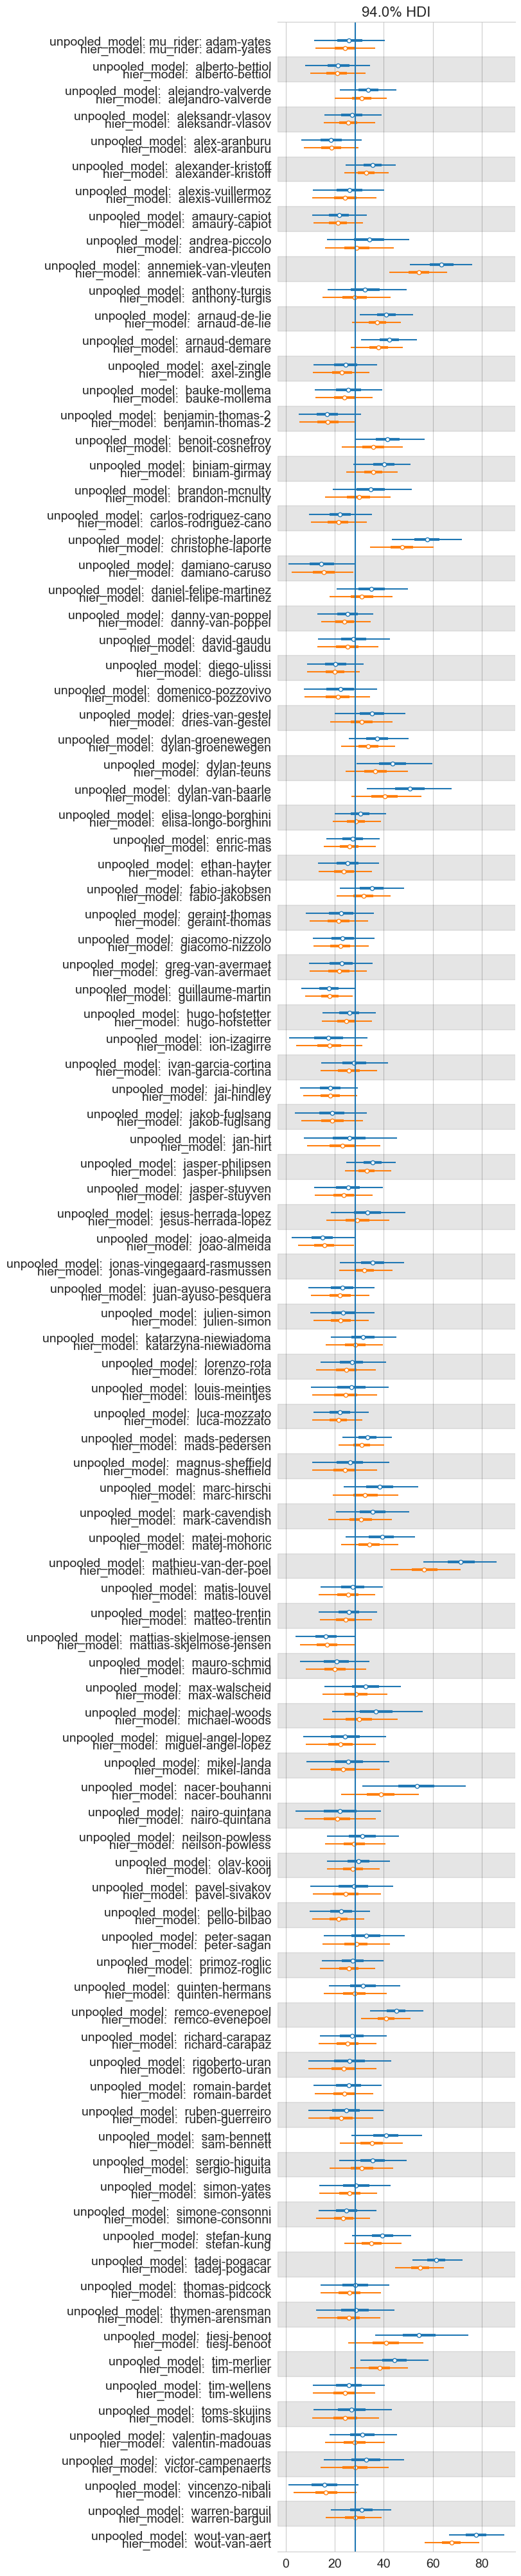

In [563]:
axes = az.plot_forest([trace_unpooled, trace_hier], model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_rider', hdi_prob=0.94, coords={"mu_rider_dim_0": riders},  figsize=(8, 40));
#mean popularity of all songs
grand_mean = df["points"].mean()
axes[0].axvline(x=grand_mean);

### Model comparison

In [564]:
unpooled_waic = az.waic(trace_unpooled, unpooled_model)
unpooled_waic.waic

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


-11098.353004111936

In [525]:
hier_waic = az.waic(trace_hier, hier_model)
hier_waic.waic

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


-11085.315498675584

In [576]:
comp_df_2 = az.compare({"model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hier,
                      "model_pooled": trace_pooled
                     },
                      ic="waic") # ic stands for "information criterion"
comp_df_2

C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\CarloGrigioni\miniconda3\envs\hier\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of th

rank          waic     p_waic     d_waic    weight  \
model_unpooled         0 -11085.020685  78.399463   0.000000  0.821344   
model_hierarchical     1 -11085.709610  73.666667   0.688925  0.000000   
model_pooled           2 -11156.577859   9.743318  71.557173  0.178656   

                           se        dse  warning waic_scale  
model_unpooled      94.282363   0.000000     True        log  
model_hierarchical  94.863639   1.764166     True        log  
model_pooled        97.305045  17.008382     True        log

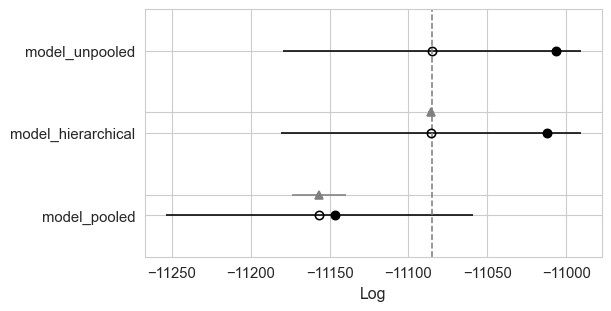

In [578]:
az.plot_compare(comp_df_2);